# General imports for plots

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm #for better display of FITS images

%matplotlib notebook

plt.rc('figure', figsize=(9,3))
plt.rcParams["image.cmap"] = "inferno"

# Interpolation tests

## Imports

In [112]:
from scipy.interpolate import UnivariateSpline, lagrange
from scipy.interpolate import Akima1DInterpolator, BarycentricInterpolator,PchipInterpolator

In [2]:
import scipy as sp

In [3]:
import numpy as np

In [4]:
from custom_numpy import arange_R_cst, arange_2d, is_sorted
from simulation_utils import gauss_ker, gaussian, SegmentedLagrange

## Def interpolations method

In [60]:
def getNDDCoeffs(x, y):
    """ Creates NDD pyramid and extracts coeffs """
    n = np.shape(y)[0]
    pyramid = np.zeros([n, n]) # Create a square matrix to hold pyramid
    pyramid[::,0] = y # first column is y
    for j in range(1,n):
        for i in range(n-j):
            # create pyramid by updating other columns
            pyramid[i][j] = (pyramid[i+1][j-1] - pyramid[i][j-1]) / (x[i+j] - x[i])
    return pyramid[0] # return first row


class Newton():
    
    def __init__(self, grid, grid_f):
        
        coeff_vector = getNDDCoeffs(grid, grid_f)
        
        # create as many polynomials as size of coeff_vector
        final_pol = np.polynomial.Polynomial([0.]) # our target polynomial
        n = coeff_vector.shape[0] # get number of coeffs
        for i in range(n):
            p = np.polynomial.Polynomial([1.]) # create a dummy polynomial
            for j in range(i):
                # each vector has degree of i
                # their terms are dependant on 'x' values
                p_temp = np.polynomial.Polynomial([-grid[j], 1.]) # (x - x_j)
                p = np.polymul(p, p_temp) # multiply dummy with expression
            p *= coeff_vector[i] # apply coefficient
            final_pol = np.polyadd(final_pol, p) # add to target polynomial

        self.p = np.flip(final_pol[0].coef, axis=0)
        
    def __call__(self, x):

        return np.polyval(self.p, x)

## Tests

In [7]:
lam_range = [1.05,1.15]  # microns
R_2 = 1200
R_simu = 12000
oversample = 2

x = arange_R_cst(*lam_range, oversample*R_simu)
y = 1 - 0.5*gaussian(x, sig=np.array([1.1/R_simu])/(2 * np.sqrt(2 * np.log(2))), x0=np.array([1.1]))

c2 = gauss_ker(FWHM=np.array([R_simu/R_2]), oversample=oversample)

y = np.convolve(y, c2, mode='same')

x, y = x[500:-500],y[500:-500]
fy = UnivariateSpline(x,y, s=0)
x2 = arange_R_cst(x[0],x[-1], 2*R_2)
y2 = fy(x2)

In [86]:
i_newton = slice(57,63)
y_newton = Newton(x2[i_newton]-x2[i_newton].mean(),y2[i_newton])(x-x2[i_newton].mean())

In [109]:
y_spline = UnivariateSpline(x2,y2, s=0)(x)
y_lagrange = SegmentedLagrange(x2,y2,5, extrapolate=True)(x)

In [113]:
y_test = lagrange(x2[57:61]-x2[57:61].mean(),y2[57:61])(x-x2[57:61].mean())
y_pchip = PchipInterpolator(x2[56:62]-x2[56:62].mean(),y2[56:62])(x-x2[56:62].mean())

<IPython.core.display.Javascript object>


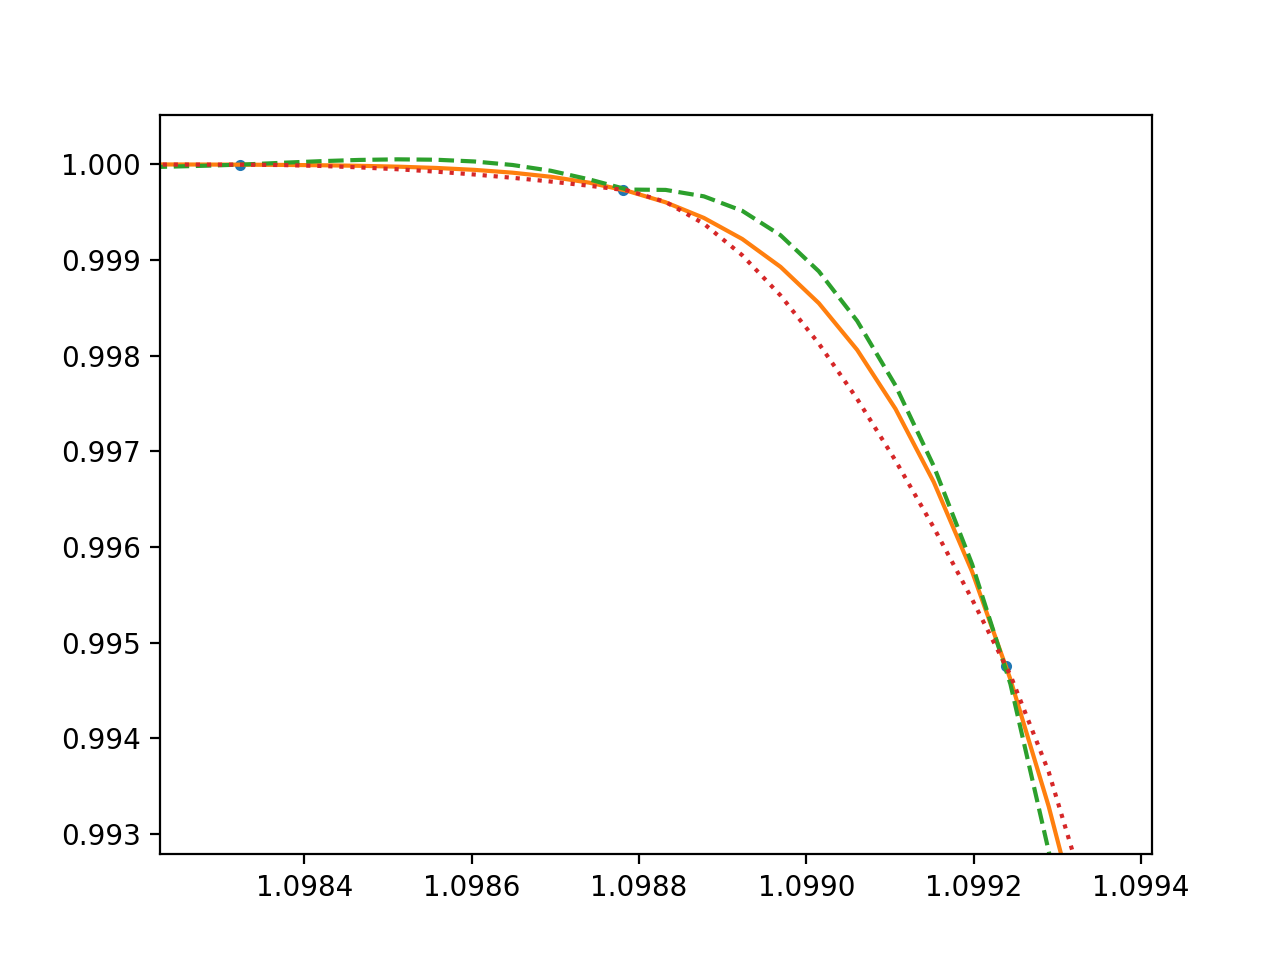

(0.965, 1.002)

In [115]:
plt.plot(x2,y2,".")
plt.plot(x,y)
# plt.plot(x2[55:65],y2[55:65],"x")
plt.plot(x,y_lagrange,"--")
plt.plot(x,y_pchip,":")

plt.ylim(0.965,1.002)

In [33]:

plt.plot(x,SegmentedLagrange(x2,y2,21, extrapolate=True)(x))

In [116]:
y_akima = Akima1DInterpolator(x2,y2)(x)
y_pchip = PchipInterpolator(x2,y2)(x)

<IPython.core.display.Javascript object>


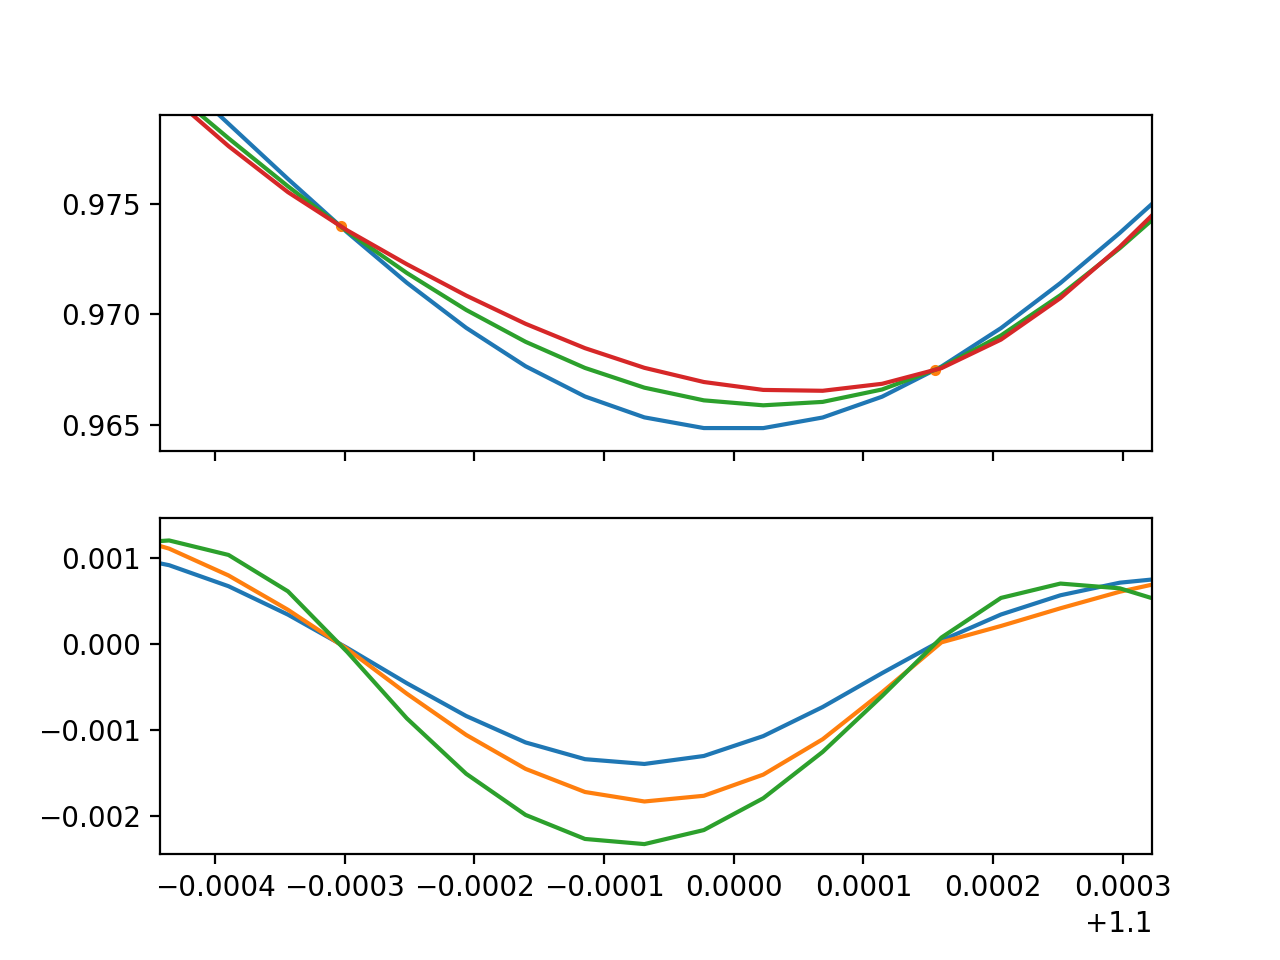

In [120]:
fig, ax = plt.subplots(2,1,sharex=True)

ax[0].plot(x,y)
ax[0].plot(x2,y2,".")
ax[0].plot(x,y_spline)
# ax[0].plot(x,y_lagrange)
ax[0].plot(x,y_akima)
# ax[0].plot(x,y_pchip)

ax[1].plot(x,(y-y_spline)/y)
ax[1].plot(x,(y-y_lagrange)/y)
ax[1].plot(x,(y-y_akima)/y)
# ax[1].plot(x,(y-y_pchip)/y)

# Extraction tests

## Imports from standard packages

In [2]:
import numpy as np
from scipy.interpolate import interp1d
from astropy.io import fits
from astropy.convolution import convolve, Box1DKernel

## Local imports

In [3]:
from overlap import TrpzOverlap
from utils import grid_from_map, oversample_grid

# Read ref files

In [4]:
# Read relevant files
wv_1 = fits.open("Ref_files/wavelengths_m1.fits")[0].data
wv_2 = fits.open("Ref_files/wavelengths_m2.fits")[0].data
T1 = fits.open("Ref_files/trace_profile_m1.fits")[0].data.squeeze()
T2 = fits.open("Ref_files/trace_profile_m2.fits")[0].data.squeeze()

# Convert to float (fits precision is 1e-8)
wv_1 = wv_1.astype(float)
wv_2 = wv_2.astype(float)
T1 = T1.astype(float)
T2 = T2.astype(float)

In [5]:
# Normalised spatial profile
P1 = T1 / T1.sum(axis=0)
P1[np.isnan(P1)] = 0.

P2 = T2 / T2.sum(axis=0)
P2[np.isnan(P2)] = 0.

/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/Users/antoinedb/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in true_divide
  """


# Setup for simulation

## Wavelength grid

In [6]:
# Use grid given by the wavelength at the center of the pixels 
# with the maximum value of the spatial profile (so one wavelength per column)
# Do it for both orders
lam_grid_2 = grid_from_map(wv_2, P2, wv_range=[0.55, wv_2.max()])
lam_grid_1 = grid_from_map(wv_1, P1, wv_range=[wv_1.min(), 3.0])

# Remove values from order 1 that are already covered by order 2
lam_grid_1 = lam_grid_1[lam_grid_1 > lam_grid_2.max()]

# Oversample by subdividing both grid and finally combine it
lam_simu = np.concatenate([oversample_grid(lam_grid_2, n_os=10), oversample_grid(lam_grid_1, n_os=10)])

# Make sure sorted and unique
lam_simu = np.unique(lam_simu)

## Initiate 2 simulations.
(One without order 2, so no contamination, and with order 2)

In [7]:
# Choose a small threshold for the spatial profile cut
# (less than for a normal extraction)
simu = TrpzOverlap([P1,P2], [wv_1,wv_2], lam_grid=lam_simu, thresh=1e-8, c_kwargs={'thresh':0.001})
simu_no_overlap = TrpzOverlap([P1], [wv_1], lam_grid=lam_simu, thresh=1e-8,c_kwargs={'thresh':0.001})

# ***** WARNING *******
# Since it's oversampled, may take some time to initiate
# (mostly because of the convolution matrix)

# Tests on sinus function

## Inject sinus

In [8]:
# Generate flux to inject
flux = 1 + 0.5 * np.sin(lam_simu*500)
# Multiplication by a fudge factor to get
# a realistic number of counts on the detector
flux *= 1e9

# Inject
scidata = simu.rebuild(flux)
clean_data = simu_no_overlap.rebuild(flux)

<IPython.core.display.Javascript object>


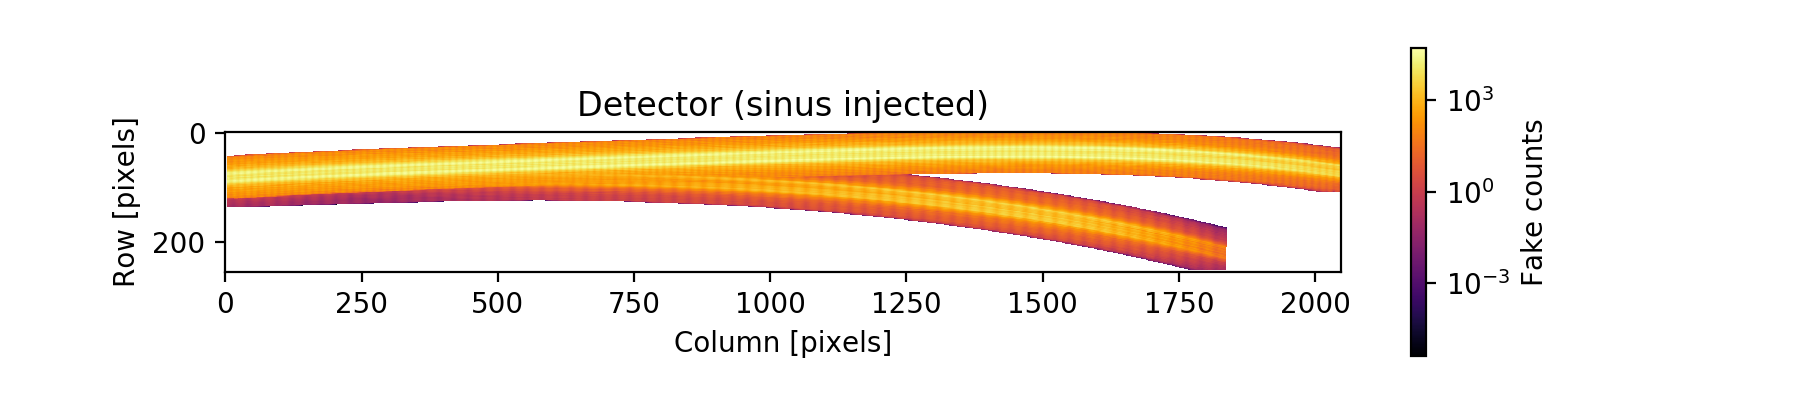

In [10]:
plt.figure(figsize=(9,2))
plt.imshow(scidata, norm=LogNorm())
cmap = plt.colorbar()
plt.title('Detector (sinus injected)')
plt.ylabel('Row [pixels]')
plt.xlabel('Column [pixels]')
cmap.set_label('Fake counts')

## Add noise

In [15]:
data_noise = scidata.copy()
clean_data_noise = clean_data.copy()

In [16]:
# Add Poisson noise
data_noise[np.isnan(data_noise)] = 0
data_noise = np.random.poisson(data_noise)
clean_data_noise[np.isnan(clean_data_noise)] = 0
clean_data_noise = np.random.poisson(clean_data_noise)

# Add background noise
data_noise = data_noise + np.random.normal(scale=20, size=data_noise.shape)
clean_data_noise = clean_data_noise + np.random.normal(scale=20, size=clean_data_noise.shape)

# Get the noise
noise = data_noise-scidata
noise_clean = clean_data_noise-clean_data

In [17]:
sig = np.sqrt(scidata + 20.**2)  # Map of expected noise

### Oversampling for a non-uniform grid
Use a finer grid for the wavelengths covered by order 2

In [11]:
# Use grid given by the wavelength at the center of the pixels 
# with the maximum value of the spatial profile (so one wavelength per column)
# Do it for both orders
lam_grid_2 = grid_from_map(wv_2, P2)
lam_grid_1 = grid_from_map(wv_1, P1)

# Remove values from order 1 that are already covered by order 2
lam_grid_1 = lam_grid_1[lam_grid_1 > lam_grid_2.max()]

In [18]:
n_oversample = [1,2,3,4,5,6,7,8]
logl = {'Noisy':[], 'Noiseless':[]}
for n_os in n_oversample:

    # Oversample by subdividing both grid and finally combine it
    lam_grid = np.concatenate([oversample_grid(lam_grid_2, n_os=n_os),
                               oversample_grid(lam_grid_1, n_os=n_os)])

    # Make sure sorted and unique
    lam_grid = np.unique(lam_grid)

    # Noiseless
    extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=scidata, lam_grid=lam_grid, thresh=1e-5,
                        c_kwargs={'thresh':0.001})
    logl['Noiseless'].append(extra.get_logl())
    
    # Noisy
    extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=data_noise, lam_grid=lam_grid, thresh=1e-5,
                        sig=sig, c_kwargs={'thresh':0.001})
    logl['Noisy'].append(extra.get_logl())

<IPython.core.display.Javascript object>


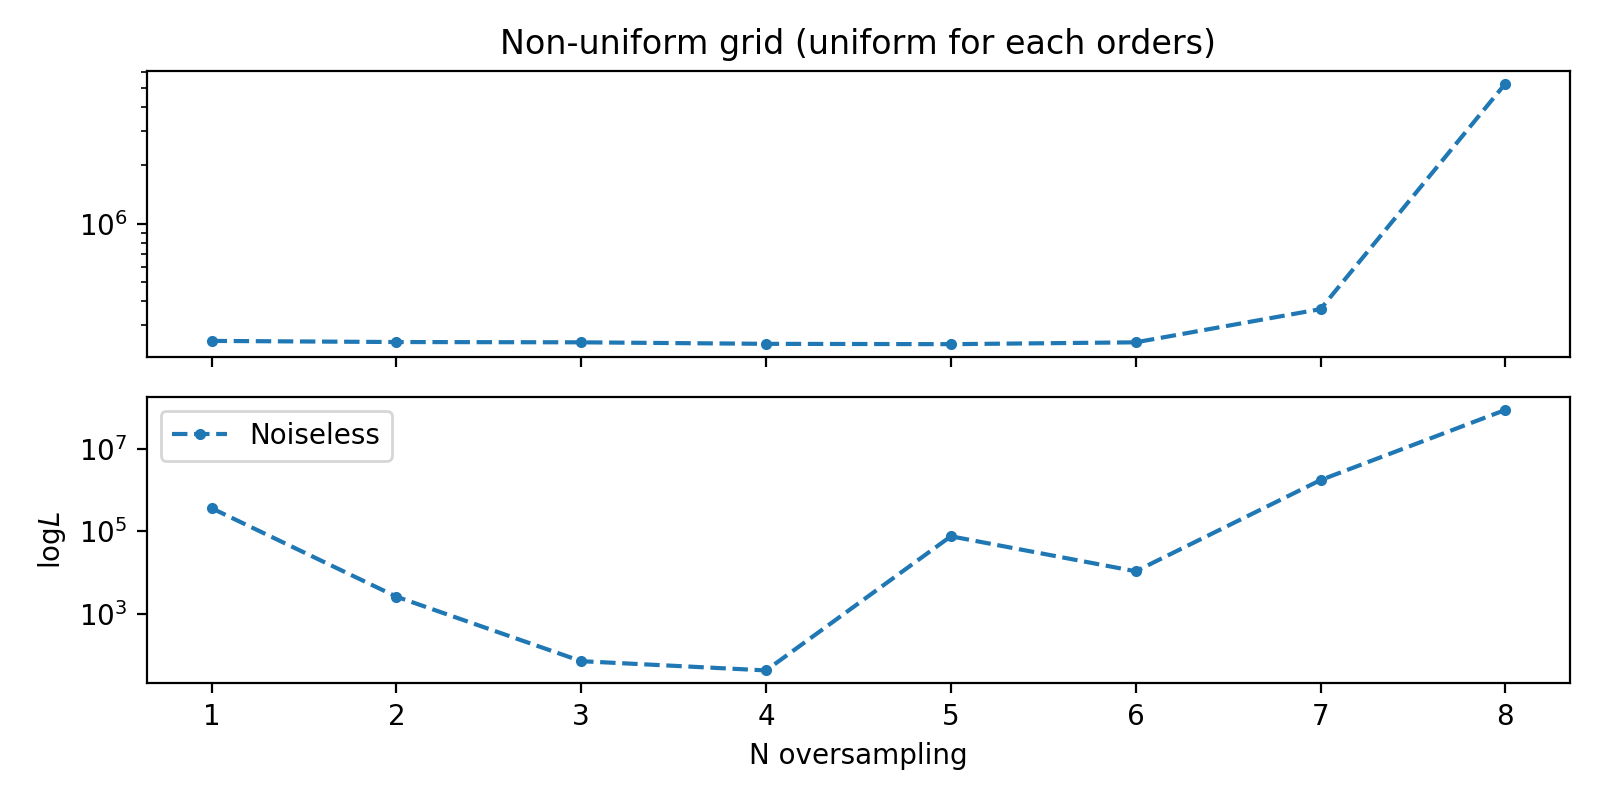

In [31]:
fig, ax = plt.subplots(2,1,sharex=True, figsize=(8,4))
for i, key in enumerate(logl.keys()):
    ax[i].semilogy(n_oversample, logl[key], "--.", label=key)
ax[0].set_title("Non-uniform grid (uniform for each orders)")
plt.xlabel('N oversampling')
plt.ylabel('$\log{L}$')
plt.legend()
plt.tight_layout()

<IPython.core.display.Javascript object>


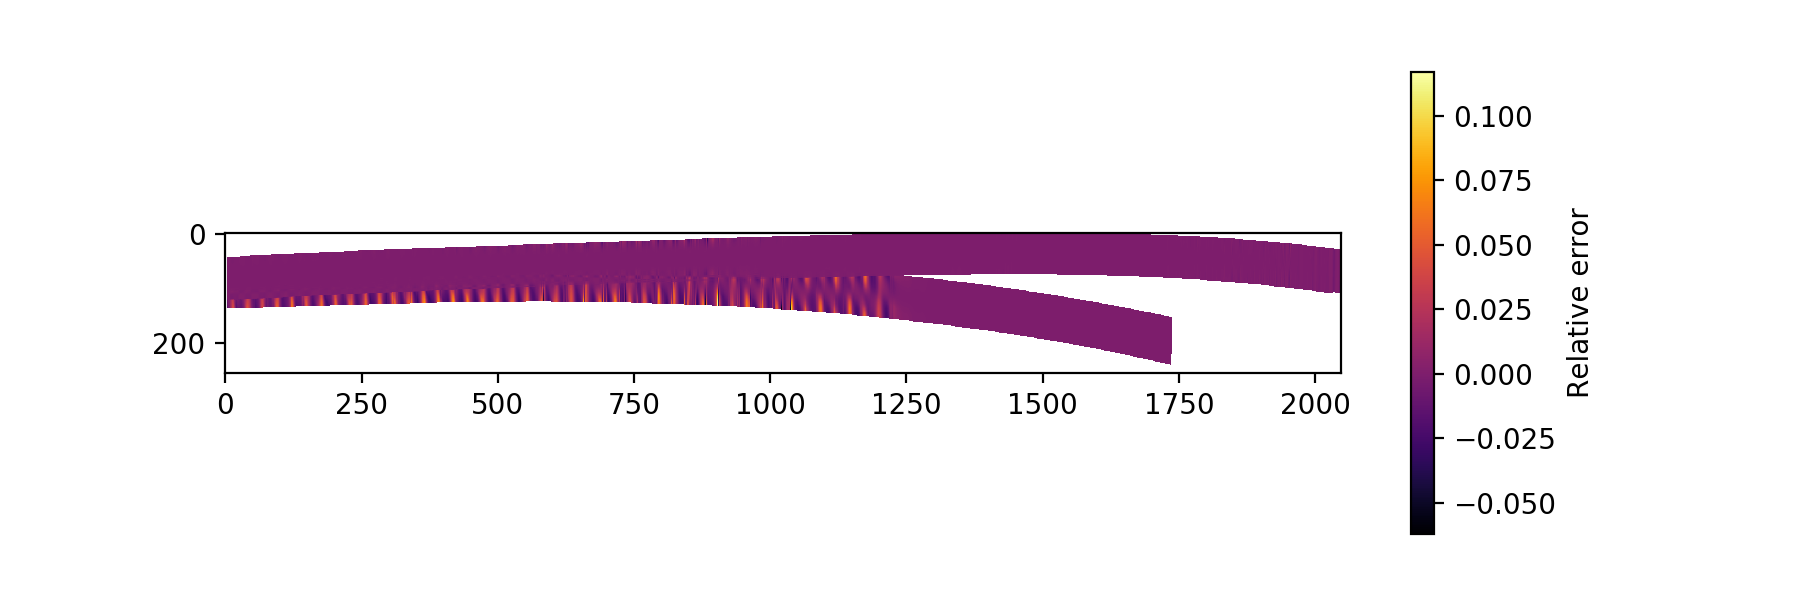

In [29]:
plt.imshow((rebuilt-scidata)/scidata)
plt.colorbar(label="Relative error")

# Case 2: Sinus function + noise

## Add noise

In [35]:
data_noise = scidata.copy()
clean_data_noise = clean_data.copy()

In [36]:
# Add Poisson noise
data_noise[np.isnan(data_noise)] = 0
data_noise = np.random.poisson(data_noise)
clean_data_noise[np.isnan(clean_data_noise)] = 0
clean_data_noise = np.random.poisson(clean_data_noise)

# Add background noise
data_noise = data_noise + np.random.normal(scale=20, size=data_noise.shape)
clean_data_noise = clean_data_noise + np.random.normal(scale=20, size=clean_data_noise.shape)

# Get the noise
noise = data_noise-scidata
noise_clean = clean_data_noise-clean_data

## Init extraction

In [59]:
sig = np.sqrt(scidata + 20.**2)  # Map of expected noise
wv_range = [0.6, 2.836]
n_oversample = 1

# Define grid for extraction
# To be improved, but for now, choose the grid from order 1
lam_grid = grid_from_map(wv_1, P1, wv_range=wv_range)
lam_grid = oversample_grid(lam_grid, n_os=n_oversample)
lam_grid = np.unique(lam_grid)

In [23]:
# Use grid given by the wavelength at the center of the pixels 
# with the maximum value of the spatial profile (so one wavelength per column)
# Do it for both orders
lam_grid_2 = grid_from_map(wv_2, P2, wv_range=[0.7, wv_2.max()])
lam_grid_1 = grid_from_map(wv_1, P1, wv_range=[wv_1.min(), 2.8])

# Revome values from order 1 that are already covered by order 2
lam_grid_1 = lam_grid_1[lam_grid_1 > lam_grid_2.max()]

# Oversample by subdividing both grid and finally combine it
lam_grid = np.concatenate([oversample_grid(lam_grid_2, n_os=n_oversample),
                           oversample_grid(lam_grid_1, n_os=n_oversample)])

# Make sure sorted and unique
lam_grid = np.unique(lam_grid)

In [60]:
# Init extraction object
# Use more restrictive cut on the spatial and the kernel
extra = TrpzOverlap([P1,P2], [wv_1,wv_2], scidata=data_noise, lam_grid=lam_grid, thresh=1e-5,
                     c_kwargs={'thresh':0.001}, sig=sig)

In [61]:
f_k = extra.extract()

In [62]:
rebuilt = extra.rebuild(f_k)

<IPython.core.display.Javascript object>


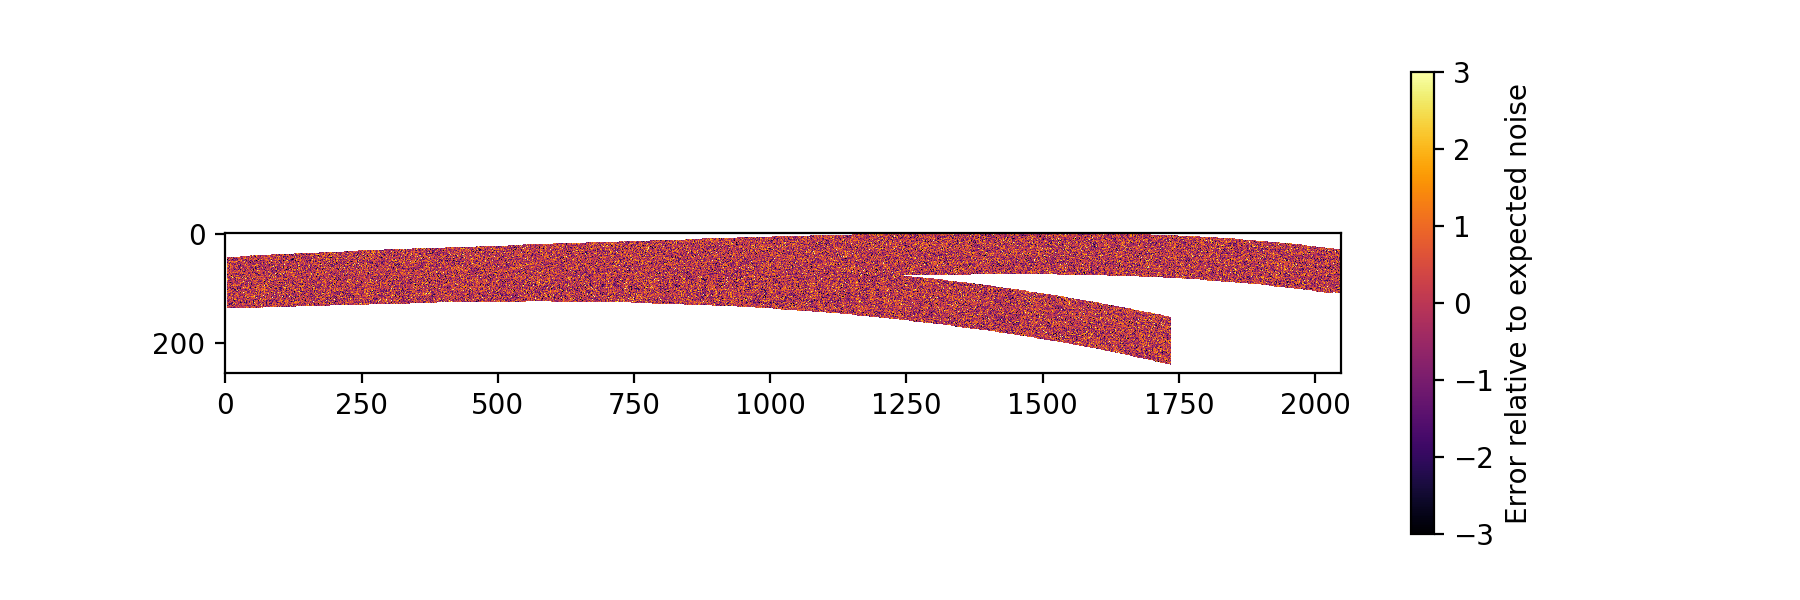

In [63]:
plt.imshow((rebuilt-data_noise)/sig, vmin=-3, vmax=3)
plt.colorbar(label="Error relative to expected noise")